# Assignment 3 Option 2

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

from milligrad import Tensor, Adam

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

## 0.1 Loading and processing data

In [2]:
names, labels = [], []
with open("ascii_names.txt", "r") as f:
    for line in f:
        *name, label = line.split(" ") # *name since people can have names split by spaces like: De Santis
        name = " ".join(name)
        names.append(name.upper())
        # Append the label to the labels list, converting it to an integer
        labels.append(int(label.replace("\n","")))

In [3]:
ids_to_chr = {i:c for i,c in enumerate(sorted(set("".join(names))))} # find all unique characters, sort them and give them a unique id

# add unique <PAD> token to pad the names to have the same length as the longest name in a batch (cannot construct a Tensor if they have variable lengths)
PAD = "." # normally <PAD> is used but that requires extra considerations when tokenizing (longest substring), so I just use a space
PAD_ID = len(ids_to_chr)
ids_to_chr[PAD_ID] = PAD

chr_to_ids = {c:i for i,c in ids_to_chr.items()}

In [4]:
ids_to_chr.items()

dict_items([(0, ' '), (1, "'"), (2, 'A'), (3, 'B'), (4, 'C'), (5, 'D'), (6, 'E'), (7, 'F'), (8, 'G'), (9, 'H'), (10, 'I'), (11, 'J'), (12, 'K'), (13, 'L'), (14, 'M'), (15, 'N'), (16, 'O'), (17, 'P'), (18, 'Q'), (19, 'R'), (20, 'S'), (21, 'T'), (22, 'U'), (23, 'V'), (24, 'W'), (25, 'X'), (26, 'Y'), (27, 'Z'), (28, '.')])

In [5]:
### Pad all names to have the same length as the longest name (14 characters)
n_len = max(len(n) for n in names)
names = [n + " "*(n_len-len(n)) for n in names]

In [6]:
tokenized_names = np.array([[chr_to_ids[c] for c in name] for name in names])
tokenized_names = np.eye(len(chr_to_ids))[tokenized_names].swapaxes(1,2) # one hot encode and make the length be the last dimension
labels = np.array(labels)
labels_ohe = np.eye(max(labels))[labels-1] # one hot encode

In [7]:
np.random.seed(1337)

N_TRAIN = int(0.7 * len(names))
N_VAL = int(0.2 * len(names))
N_TEST = len(names) - N_TRAIN - N_VAL

shuffle = np.random.permutation(np.arange(len(names)))

x_train, y_train = tokenized_names[shuffle[:N_TRAIN]], labels_ohe[shuffle[:N_TRAIN]]
x_val, y_val = tokenized_names[shuffle[N_TRAIN:N_TRAIN+N_VAL]], labels_ohe[shuffle[N_TRAIN:N_TRAIN+N_VAL]]
x_test, y_test = tokenized_names[shuffle[N_TRAIN+N_VAL:]], labels_ohe[shuffle[N_TRAIN+N_VAL:]]

## 0.2 Hyperparameters

In [8]:
C_IN = len(chr_to_ids)
C_H1 = 20
C_H2 = 20
K1 = 5
K2 = 3
PADDING = 0

SEQ_LEN = n_len
NUM_CLASSES = max(labels)

## 0.3-0.4 Setting up the model

In [9]:
# does not have special considerations for the sparsity of the data since my aim was to make a generalized convolution 
class SurnameConvNet:
    def __init__(self):
        self.w_out = (SEQ_LEN - K1 + 2*PADDING + 1) \
              - K2 + 2*PADDING + 1

        self.ki = Tensor.randn(C_IN, K1, C_H1) * 0.01
        self.kh = Tensor.randn(C_H1, K2, C_H2) * 0.01

        self.wo = Tensor.xavier(self.w_out * C_H2, NUM_CLASSES)
        self.bo = Tensor.zeros(NUM_CLASSES)

    def __call__(self, x:Tensor)->Tensor:
        x = x.conv1d(self.ki, padding=PADDING).relu()
        x = x.conv1d(self.kh, padding=PADDING).relu()
        x = x.reshape(-1, self.w_out * C_H2)
        return x @ self.wo + self.bo
    
    def parameters(self)->list[Tensor]:
        return [self.ki, self.kh, self.wo, self.bo]


model = SurnameConvNet()
out = model(Tensor.randn(32, C_IN, SEQ_LEN))
out.shape

(32, 18)

In [10]:
from milligrad import topological_sort

[x._grad_fn for x in reversed(topological_sort(out))]
#['+', '@', 'reshape', 'relu', 'conv1d', 'relu', 'conv1d', '', '*', '', '', '*', '', '', '', '']

['+',
 '@',
 'reshape',
 'relu',
 'conv1d',
 'relu',
 'conv1d',
 '',
 '*',
 '',
 '',
 '*',
 '',
 '',
 '',
 '']

Verifying the correctness of the forward and backward passes

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TorchSurnameConvNet(nn.Module):
    def __init__(self):
        super(TorchSurnameConvNet, self).__init__()
        self.w_out = (SEQ_LEN - K1 + 2 * PADDING + 1) - K2 + 2 * PADDING + 1
        
        self.conv1 = nn.Conv1d(C_IN, C_H1, K1, padding=PADDING, bias=False)
        self.conv2 = nn.Conv1d(C_H1, C_H2, K2, padding=PADDING, bias=False)
        self.fc = nn.Linear(self.w_out * C_H2, NUM_CLASSES)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        return self.fc(x)
    
    def copy_weights_from(self, milli_model):
        with torch.no_grad():
            self.conv1.weight.copy_(torch.tensor(milli_model.ki.data.transpose(2,0,1))) # torch is (c_out, c_in, kernel_size)
            self.conv2.weight.copy_(torch.tensor(milli_model.kh.data.transpose(2,0,1)))
            self.fc.weight.copy_(torch.tensor(milli_model.wo.data.transpose(1,0))) # torch is (d_out, d_in)
            self.fc.bias.copy_(torch.tensor(milli_model.bo.data))

model = TorchSurnameConvNet()
model(torch.randn(32, C_IN, SEQ_LEN)).shape

torch.Size([32, 18])

In [12]:
milli_model = SurnameConvNet()
torch_model = TorchSurnameConvNet()
torch_model.copy_weights_from(milli_model)

x_np = np.random.randn(32, C_IN, SEQ_LEN).astype(np.float32)
x_milli, x_torch = Tensor(x_np), torch.tensor(x_np, requires_grad=True)

y_hat_milli, y_hat_torch = milli_model(x_milli), torch_model(x_torch)

np.testing.assert_allclose(
    y_hat_milli.data, y_hat_torch.detach().cpu(),
    err_msg="Forwards pass mismatch", atol=1e-5
)

y_hat_milli.sum().backward()
y_hat_torch.sum().backward()

np.testing.assert_allclose(
    milli_model.bo.grad, torch_model.fc.bias.grad.detach().numpy(),
    err_msg="Backwards pass mismatch", atol=1e-5
)

np.testing.assert_allclose(
    milli_model.wo.grad.transpose(1,0), torch_model.fc.weight.grad.detach().numpy(),
    err_msg="Backwards pass mismatch", atol=1e-5
)

np.testing.assert_allclose(
    milli_model.kh.grad.transpose(2,0,1), torch_model.conv2.weight.grad.detach().numpy(),
    err_msg="Backwards pass mismatch", atol=1e-5
)

np.testing.assert_allclose(
    milli_model.ki.grad.transpose(2,0,1), torch_model.conv1.weight.grad.detach().numpy(),
    err_msg="Backwards pass mismatch", atol=1e-5
)

### 0.5 Train using mini-batch gradient descent with momentum:

In [13]:
class Momentum:
    def __init__(self, params:list[Tensor], lr:float=0.01, momentum:float=0.9):
        self.params = params
        self.lr = lr
        self.momentum = momentum
        self.velocities = [np.zeros_like(p.data) for p in self.params]

    def step(self):
        for i, p in enumerate(self.params):
            self.velocities[i] = self.momentum * self.velocities[i] + self.lr * p.grad
            p.data -= self.velocities[i]

    def zero_grad(self):
        for p in self.params:
            p.grad = np.zeros_like(p.grad)

In [14]:
def accuracy(y, y_hat):
    return (y.argmax(axis=-1)==y_hat.argmax(axis=-1)).mean()

In [15]:
EPOCHS = 100
BATCH_SIZE = 128
LR = 1e-3

model = SurnameConvNet()
optim = Momentum(model.parameters())

train_losses_epoch = []
val_losses_epoch = []
val_accuracies_epoch = []

for epoch in range(EPOCHS):
    train_shuffle = np.random.permutation(len(x_train))
    train_tqdm = tqdm(range(0, len(x_train) // BATCH_SIZE - 1), desc=f"Epoch {epoch + 1}/{EPOCHS} Training")
    train_losses = []
    for i in train_tqdm:
        idxs = train_shuffle[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]

        x = Tensor(x_train[idxs])
        y = Tensor(y_train[idxs])  # y is one-hot encoded

        y_hat = model(x)

        loss = -(y * y_hat.log_softmax()).sum(-1).mean()  # sum over classes, mean over batch

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_tqdm.set_postfix({"loss": loss.data})
        train_losses.append(loss.data)

    val_losses = []
    val_accuracies = []
    for i in range(0, len(x_val), BATCH_SIZE):
        x_batch = Tensor(x_val[i:i+BATCH_SIZE])
        y_batch = Tensor(y_val[i:i+BATCH_SIZE])
        
        y_hat = model(x_batch)
        
        loss = -(y_batch * y_hat.log_softmax()).sum(1).mean().data
        acc = accuracy(y_batch.data, y_hat.data)
        
        val_losses.append(loss)
        val_accuracies.append(acc)

    train_losses_epoch.append(np.mean(train_losses))
    val_losses_epoch.append(np.mean(val_losses))
    val_accuracies_epoch.append(np.mean(val_accuracies))

Epoch 1/100 Training:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 100/100 Training: 100%|██████████| 108/108 [00:01<00:00, 58.18it/s, loss=0.5653269] 


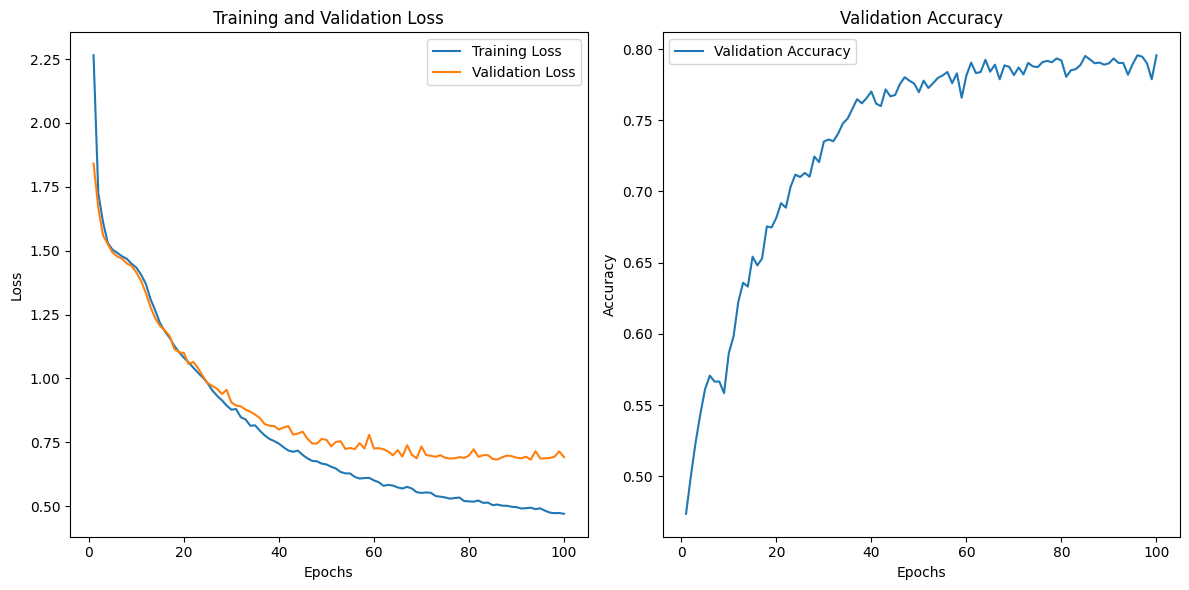

In [16]:
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses_epoch, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), val_losses_epoch, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), val_accuracies_epoch, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
accuracy(y_test, model(Tensor(x_test)).data)

0.7950124688279302

In [18]:
!pip install seaborn

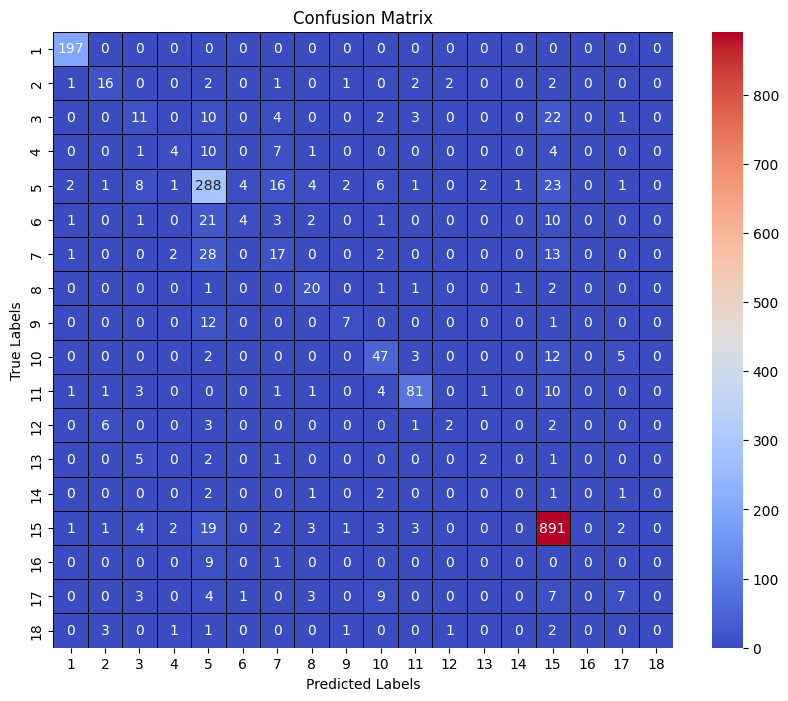

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def make_confusion_matrix(model, x, y):
    y_true = y.argmax(axis=-1)
    y_hat = model(Tensor(x)).data.argmax(axis=-1)
    
    num_classes = len(np.unique(y_true))  # Calculate the number of classes based on y_true
    cm = np.zeros((num_classes, num_classes), dtype=int)
    
    for true, pred in zip(y_true, y_hat):
        cm[true, pred] += 1
    
    return cm

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=class_names, yticklabels=class_names, linewidths=0.5, linecolor='black')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

confusion_matrix = make_confusion_matrix(model, x_test, y_test)
plot_confusion_matrix(confusion_matrix, range(1, n_len))

The confusion matrix shows some concentration along the diagonal, indicating correct predictions. However, there are significant off-diagonal values, highlighting misclassifications.

Class 15 has a high number of correct predictions (841), due to a higher frequency in the dataset.


This confusion matrix directly represents the training data distribution as can be seen in the next section.

### 0.6 Account for the unbalanced dataset

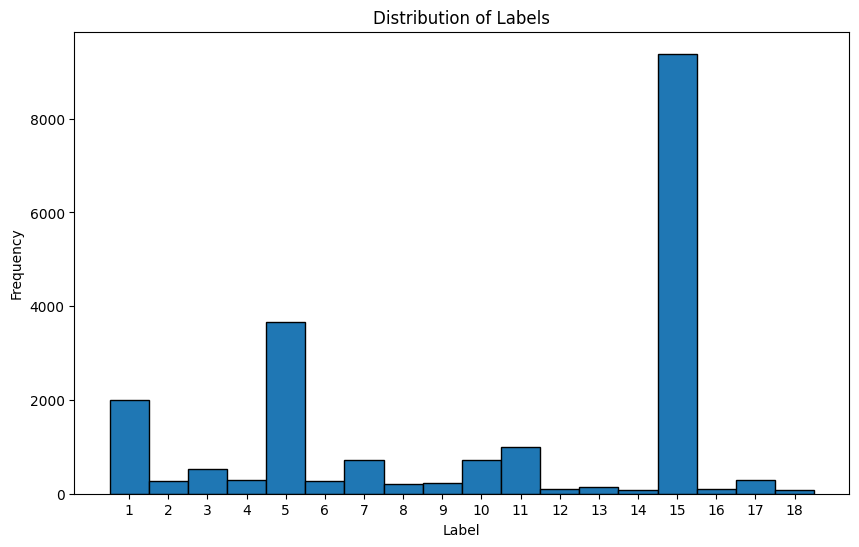

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(labels, bins=range(min(labels), max(labels) + 2), edgecolor='black', align='left')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Distribution of Labels')
plt.xticks(range(min(labels), max(labels) + 1))
plt.show()

I opted for weighing the loss function


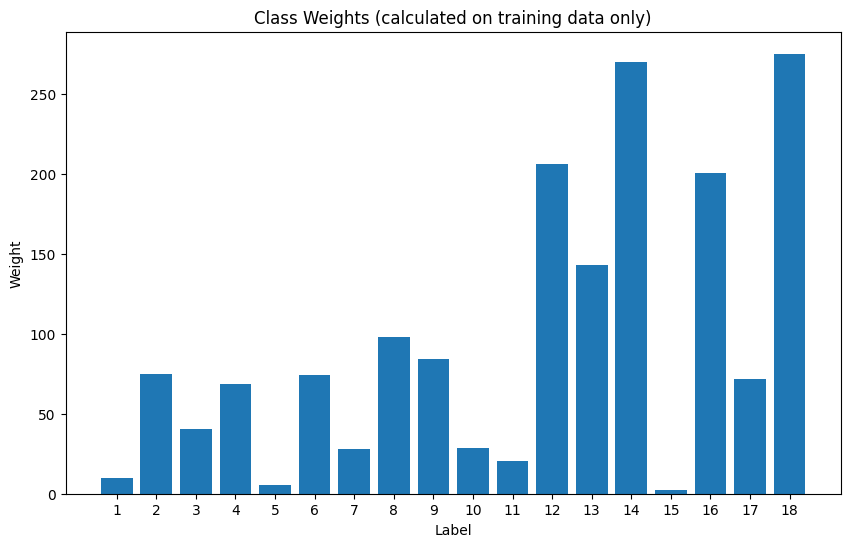

In [21]:
from collections import Counter

label_counts = Counter(y_train.argmax(-1))
total_samples = sum(label_counts.values())
class_weights = {label: total_samples / count for label, count in label_counts.items()}

weights = np.array([class_weights[i] for i in sorted(class_weights.keys())], dtype=np.float32)


plt.figure(figsize=(10, 6))
plt.bar(range(len(weights)), weights, tick_label=range(1,n_len))

plt.xlabel('Label')
plt.ylabel('Weight')
plt.title('Class Weights (calculated on training data only)')

plt.show()


In [22]:
class_weights = Tensor(weights)

model = SurnameConvNet()
optim = Momentum(model.parameters())

train_losses_epoch = []
val_losses_epoch = []
val_accuracies_epoch = []

for epoch in range(EPOCHS):
    train_shuffle = np.random.permutation(len(x_train))
    train_tqdm = tqdm(range(0, len(x_train) // BATCH_SIZE - 1), desc=f"Epoch {epoch + 1}/{EPOCHS} Training")
    train_losses = []
    for i in train_tqdm:
        idxs = train_shuffle[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]

        x = Tensor(x_train[idxs])
        y = Tensor(y_train[idxs])  # y is one-hot encoded

        y_hat = model(x)

        loss = -(y * class_weights * y_hat.log_softmax()).sum(-1).mean()  # sum over classes, mean over batch

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_tqdm.set_postfix({"loss": loss.data})
        train_losses.append(loss.data)

    val_losses = []
    val_accuracies = []
    for i in range(0, len(x_val), BATCH_SIZE):
        x = Tensor(x_val[i:i+BATCH_SIZE])
        y = Tensor(y_val[i:i+BATCH_SIZE])
        
        y_hat = model(x)
        
        loss = -(y * class_weights * y_hat.log_softmax()).sum(-1).mean().data
        acc = accuracy(y.data, y_hat.data)
        
        val_losses.append(loss)
        val_accuracies.append(acc)

    train_losses_epoch.append(np.mean(train_losses))
    val_losses_epoch.append(np.mean(val_losses))
    val_accuracies_epoch.append(np.mean(val_accuracies))

Epoch 1/100 Training:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 100/100 Training: 100%|██████████| 108/108 [00:02<00:00, 52.42it/s, loss=35.319458] 


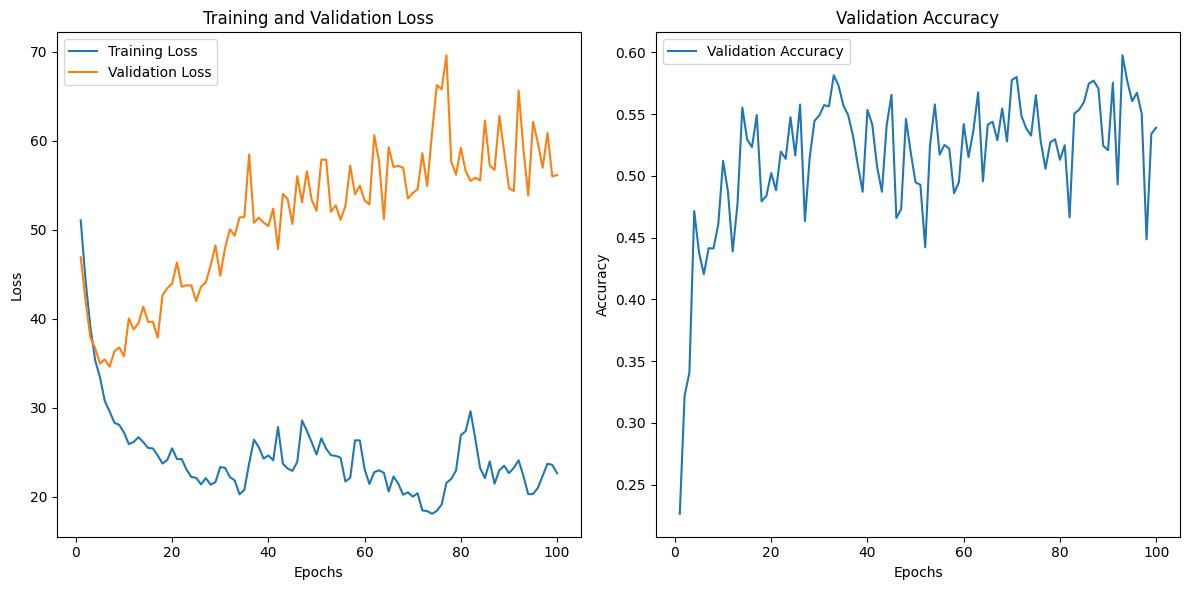

In [23]:
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses_epoch, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), val_losses_epoch, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), val_accuracies_epoch, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
accuracy(y_test, model(Tensor(x_test)).data)

0.5291770573566085

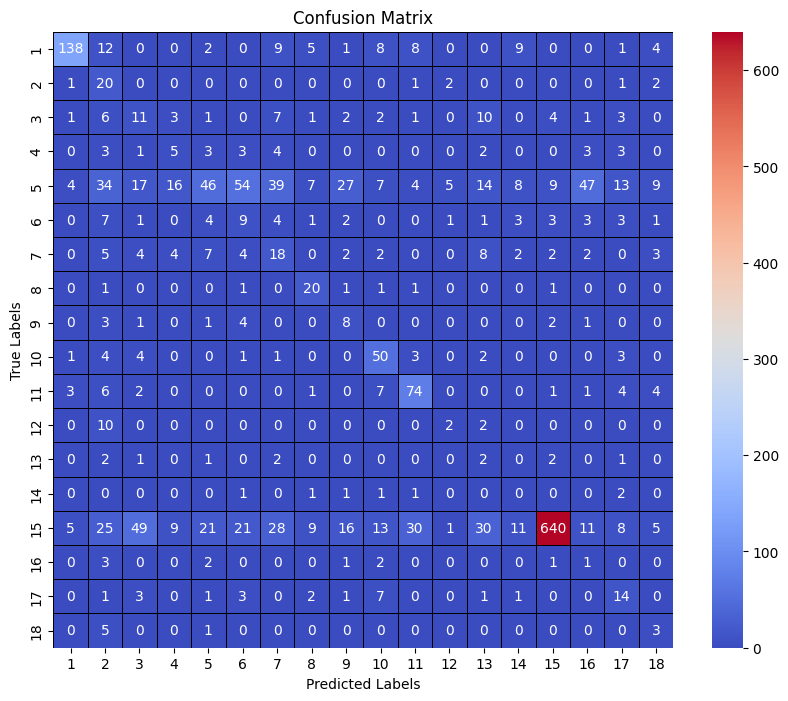

In [25]:
confusion_matrix = make_confusion_matrix(model, x_test, y_test)
plot_confusion_matrix(confusion_matrix, range(1, n_len))

There is a noticeable concentration along the diagonal, indicating correct predictions. However, there is also a signficant amount of off-diagonal values.


Class 15 remains highly accurate with a significant number of correct predictions (673), likely reflecting its higher frequency in the dataset.
Some classes like 5 and 11 show improved but still dispersed predictions, indicating that while the model is better, it still faces challenges distinguishing these classes.

In [26]:
def class_wise_accuracy_from_cm(cm):
    correct_predictions = np.diag(cm)
    total_predictions = np.sum(cm, axis=1)
    class_accuracies = correct_predictions / total_predictions
    return class_accuracies

accs = class_wise_accuracy_from_cm(make_confusion_matrix(model, x_test, y_test))

for i, acc in enumerate(accs):
    print(f"Class {i+1} has {acc:.2%} test accuracy")


Class 1 has 70.05% test accuracy
Class 2 has 74.07% test accuracy
Class 3 has 20.75% test accuracy
Class 4 has 18.52% test accuracy
Class 5 has 12.78% test accuracy
Class 6 has 20.93% test accuracy
Class 7 has 28.57% test accuracy
Class 8 has 76.92% test accuracy
Class 9 has 40.00% test accuracy
Class 10 has 72.46% test accuracy
Class 11 has 71.84% test accuracy
Class 12 has 14.29% test accuracy
Class 13 has 18.18% test accuracy
Class 14 has 0.00% test accuracy
Class 15 has 68.67% test accuracy
Class 16 has 10.00% test accuracy
Class 17 has 41.18% test accuracy
Class 18 has 33.33% test accuracy


In [27]:
chr_to_ids

{' ': 0,
 "'": 1,
 'A': 2,
 'B': 3,
 'C': 4,
 'D': 5,
 'E': 6,
 'F': 7,
 'G': 8,
 'H': 9,
 'I': 10,
 'J': 11,
 'K': 12,
 'L': 13,
 'M': 14,
 'N': 15,
 'O': 16,
 'P': 17,
 'Q': 18,
 'R': 19,
 'S': 20,
 'T': 21,
 'U': 22,
 'V': 23,
 'W': 24,
 'X': 25,
 'Y': 26,
 'Z': 27,
 '.': 28}

In [28]:
names = ["Bjarnson", "Rosengren", "Vincent", "Axelsson", "Oskarsson"]
names = [n.upper() for n in names]
names = [n + " "*(n_len-len(n)) for n in names]
tokenized_names = np.array([[chr_to_ids[c] for c in name] for name in names])
tokenized_names = np.eye(len(chr_to_ids))[tokenized_names].swapaxes(1,2)

predicted_surnames = model(Tensor(tokenized_names)).softmax()
predicted_surnames

Tensor([[5.92058292e-03, 4.98524010e-02, 4.23432095e-03, 6.12478741e-02,
        3.12646538e-01, 1.17612399e-01, 2.40526833e-02, 2.05845008e-05,
        4.46278788e-02, 6.81738257e-02, 1.82287462e-04, 6.18296108e-05,
        5.37589309e-04, 2.00934913e-02, 1.45428730e-02, 1.82284430e-01,
        9.34440717e-02, 4.64279816e-04],
       [6.31316099e-04, 1.34451303e-03, 3.02075110e-02, 3.54456097e-01,
        1.25292525e-01, 1.39934391e-01, 4.50546667e-02, 4.24576225e-04,
        5.69306090e-02, 6.87591136e-02, 1.06162217e-03, 1.02849654e-03,
        1.88399339e-04, 3.92321264e-03, 1.36634270e-02, 4.89469478e-03,
        1.51094988e-01, 1.10974337e-03],
       [5.11959242e-03, 2.13030875e-02, 3.87780853e-02, 9.12732556e-02,
        1.46532908e-01, 2.46708810e-01, 1.23150736e-01, 1.01190782e-03,
        8.48345011e-02, 4.20749560e-02, 8.82051419e-03, 1.53487250e-02,
        2.81900656e-03, 6.83426857e-03, 1.62092466e-02, 3.32670100e-02,
        9.93972421e-02, 1.65161267e-02],
       [2.34

In [29]:
for name, prob in zip(names, predicted_surnames):
    print(name, [f"{p:.2%}" for p in prob.data])

BJARNSON            ['0.59%', '4.99%', '0.42%', '6.12%', '31.26%', '11.76%', '2.41%', '0.00%', '4.46%', '6.82%', '0.02%', '0.01%', '0.05%', '2.01%', '1.45%', '18.23%', '9.34%', '0.05%']
ROSENGREN           ['0.06%', '0.13%', '3.02%', '35.45%', '12.53%', '13.99%', '4.51%', '0.04%', '5.69%', '6.88%', '0.11%', '0.10%', '0.02%', '0.39%', '1.37%', '0.49%', '15.11%', '0.11%']
VINCENT             ['0.51%', '2.13%', '3.88%', '9.13%', '14.65%', '24.67%', '12.32%', '0.10%', '8.48%', '4.21%', '0.88%', '1.53%', '0.28%', '0.68%', '1.62%', '3.33%', '9.94%', '1.65%']
AXELSSON            ['0.00%', '0.00%', '0.00%', '0.03%', '0.05%', '0.12%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '99.81%', '0.00%', '0.00%']
OSKARSSON           ['0.00%', '0.00%', '0.00%', '0.01%', '93.88%', '1.69%', '0.48%', '0.19%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.00%', '0.24%', '3.49%', '0.00%', '0.00%']


In [30]:
for name, prob in zip(names, predicted_surnames):
    print(name, prob.data.argmax())

BJARNSON            4
ROSENGREN           3
VINCENT             5
AXELSSON            15
OSKARSSON           4


### Efficiency gains

In [31]:
import timeit

batch_size = 32
c_in = 100
kernel_size = 5
c_out = 200
padding = 2

times_slow = []
times_fast = []

seq_lens = [10, 50, 100, 200, 500, 1000]

for seq_len in tqdm(seq_lens):
    tensor = Tensor.randn(batch_size, c_in, seq_len)
    kernel = Tensor.randn(c_in, kernel_size, c_out) 

    time_slow = timeit.timeit(lambda: tensor.conv1d_slow(kernel, padding), number=10)
    time_fast = timeit.timeit(lambda: tensor.conv1d(kernel, padding), number=10)
    times_slow.append(time_slow)
    times_fast.append(time_fast)

  0%|          | 0/6 [00:00<?, ?it/s]

AttributeError: 'Tensor' object has no attribute 'conv1d_slow'

In [ ]:
f"{times_slow[-1] / times_fast[-1]:.2%}"

'4056.97%'

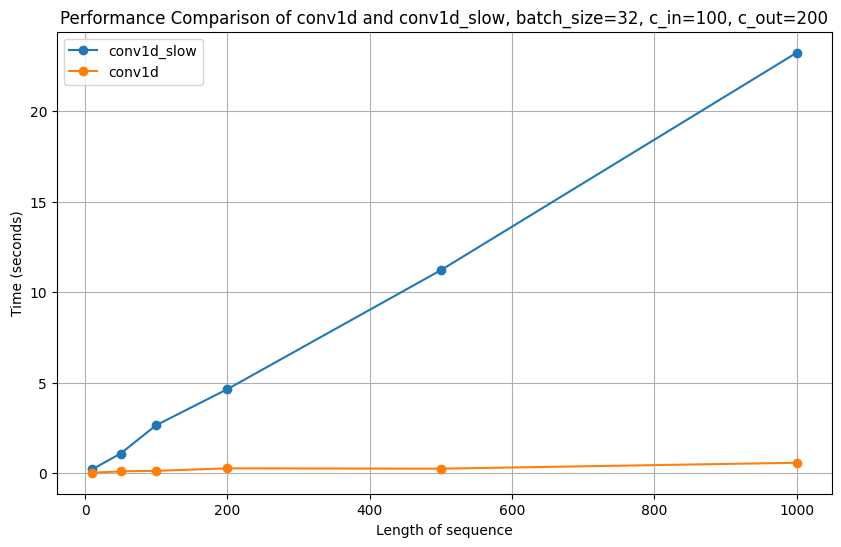

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(seq_lens, times_slow, label='conv1d_slow', marker='o')
plt.plot(seq_lens, times_fast, label='conv1d', marker='o')
plt.xlabel('Length of sequence')
plt.ylabel('Time (seconds)')
plt.title(f'Performance Comparison of conv1d and conv1d_slow, {batch_size=}, {c_in=}, {c_out=}')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
times_slow = []
times_fast = []

seq_len = 200
batch_sizes = [16, 32, 128, 256, 512]

for batch_size in tqdm(batch_sizes):
    tensor = Tensor.randn(batch_size, c_in, seq_len)
    kernel = Tensor.randn(c_in, kernel_size, c_out) 

    time_slow = timeit.timeit(lambda: tensor.conv1d_slow(kernel, padding), number=10)
    time_fast = timeit.timeit(lambda: tensor.conv1d(kernel, padding), number=10)
    times_slow.append(time_slow)
    times_fast.append(time_fast)

100%|██████████| 5/5 [02:20<00:00, 28.12s/it]


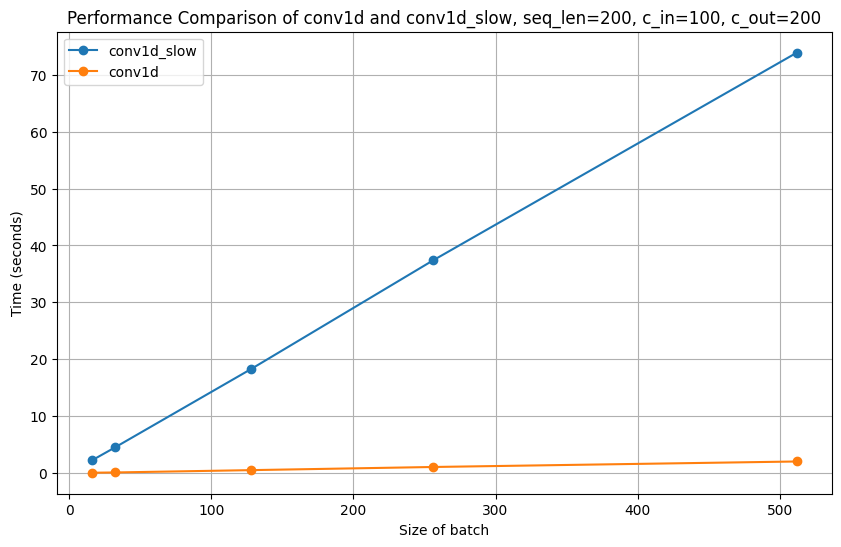

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, times_slow, label='conv1d_slow', marker='o')
plt.plot(batch_sizes, times_fast, label='conv1d', marker='o')
plt.xlabel('Size of batch')
plt.ylabel('Time (seconds)')
plt.title(f'Performance Comparison of conv1d and conv1d_slow, {seq_len=}, {c_in=}, {c_out=}')
plt.legend()
plt.grid(True)
plt.show()